In [1]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 6.2 kB/s 
     |████████████████████████████████| 1.6 MB 58.8 MB/s 
     |████████████████████████████████| 438 kB 67.0 MB/s 
     |████████████████████████████████| 5.8 MB 54.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

In [ ]:
#split each chunks into  train and test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from  scipy import stats
from statsmodels.tsa.stattools import pacf
import math
import keras 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
rcParams['figure.figsize'] = 18,15
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42  
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/omlstreaming-grc-datasets-traffic-ctrl-67a90f9/traffic-prediction-dataset - Copy.csv',parse_dates=['timestamp'], index_col='timestamp')
df.head()
df['minute'] = df.index.minute
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month
df.head()

,Cross 1,Cross 2,Cross 3,Cross 4,Cross 5,Cross 6,minute,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,
2015-01-01 00:00:00,105.0,48.0,30,62.0,31,110.0,0,0,3,1,1
2015-01-01 00:05:00,97.0,41.0,32,55.0,42,103.0,5,0,3,1,1
2015-01-01 00:10:00,76.0,47.0,44,58.0,40,100.0,10,0,3,1,1
2015-01-01 00:15:00,98.0,40.0,39,59.0,43,104.0,15,0,3,1,1
2015-01-01 00:20:00,87.0,41.0,47,49.0,35,112.0,20,0,3,1,1


In [ ]:
sns.lineplot(x=df.index,y='Cross 1',data=df)

In [ ]:
sns.lineplot(data=df,x='Cross 1',y='day_of_week')

In [ ]:
train_size = int(len(df)*0.80)
test_size = len(df)-train_size
train, test = df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(train.shape, test.shape)
col = ['Cross 1','Cross 2','Cross 3','Cross 4','Cross 5','Cross 6']
train


(12902, 11) (3226, 11)


,Cross 1,Cross 2,Cross 3,Cross 4,Cross 5,Cross 6,minute,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,
2015-01-01 00:00:00,105.0,48.0,30,62.0,31,110.0,0,0,3,1,1
2015-01-01 00:05:00,97.0,41.0,32,55.0,42,103.0,5,0,3,1,1
2015-01-01 00:10:00,76.0,47.0,44,58.0,40,100.0,10,0,3,1,1
2015-01-01 00:15:00,98.0,40.0,39,59.0,43,104.0,15,0,3,1,1
2015-01-01 00:20:00,87.0,41.0,47,49.0,35,112.0,20,0,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2015-02-14 18:43:00,227.0,111.0,98,231.0,159,198.0,43,18,5,14,2
2015-02-14 18:48:00,237.0,108.0,88,200.0,82,202.0,48,18,5,14,2
2015-02-14 18:53:00,212.0,101.0,96,172.0,86,165.0,53,18,5,14,2


In [ ]:
from sklearn.preprocessing import RobustScaler
col = ['Cross 1','Cross 2','Cross 3','Cross 4','Cross 5','Cross 6']
f_transformer = RobustScaler()
c_transformer  = RobustScaler()

f_transformer =f_transformer.fit(train[train.columns[0:6]] .to_numpy())
c_transformer =c_transformer.fit(train[train.columns[:6]])

train[train.columns[0:6]] = f_transformer.transform(train[train.columns[0:6]])
train[train.columns[:6]] = c_transformer.transform(train[train.columns[:6]])
test[test.columns[0:6]] = f_transformer.transform(test[test.columns[0:6]])
test[test.columns[:6]] = c_transformer.transform(test[test.columns[:6]])


(10321,)

In [ ]:
def create_dataset(X,y,time_steps=1):
  xs,ys  = [] ,[]
  for i in range(len(X) - time_steps):
    v = X.iloc[i: (i+time_steps)].to_numpy()
    xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(xs),np.array(ys)

In [ ]:
TIME_STEPS = 24
xtrain,ytrain = create_dataset(train, train.minute, time_steps=TIME_STEPS)
xtest,ytest = create_dataset(test, test.minute, time_steps=TIME_STEPS)
print(xtrain.shape,ytrain.shape)

(12878, 24, 11) (12878,)


In [ ]:
#[sample,time_steps,n_features]
print(xtest.shape,ytest.shape)

(3202, 24, 11) (3202,)


In [ ]:

from keras.layers import LSTMCell
model=tf.keras.Sequential()
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=120,
            input_shape=(xtrain.shape[1],xtrain.shape[2])
        )
    )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.recurrent import LSTM
"""
Hybrid Model
"""
window_size = 50
def make_model(window_size):
    model=tf.keras.Sequential()
    model.add(
        keras.layers.Bidirectional(
            keras.layers.LSTM(
                units=120,
                input_shape=(xtrain.shape[1],xtrain.shape[2])
                )
            )
        )
    return model
model = make_model(50)
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
history = model.fit(xtrain,ytrain,
                    epochs =  30,
                    batch_size=32,
                    validation_split=0.1,
                    shuffle = False)

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

363/363 [==============================] - 7s 19ms/step - loss: 1233.1146 - accuracy: 0.0000e+00 - val_loss: 1206.8180 - val_accuracy: 0.0000e+00
Epoch 2/30
363/363 [==============================] - 6s 16ms/step - loss: 1226.0956 - accuracy: 4.3141e-04 - val_loss: 1206.3016 - val_accuracy: 0.0000e+00
Epoch 3/30
363/363 [==============================] - 6s 16ms/step - loss: 1225.8579 - accuracy: 0.0029 - val_loss: 1206.0547 - val_accuracy: 0.0000e+00
Epoch 4/30
363/363 [=====================

ValueError: ignored

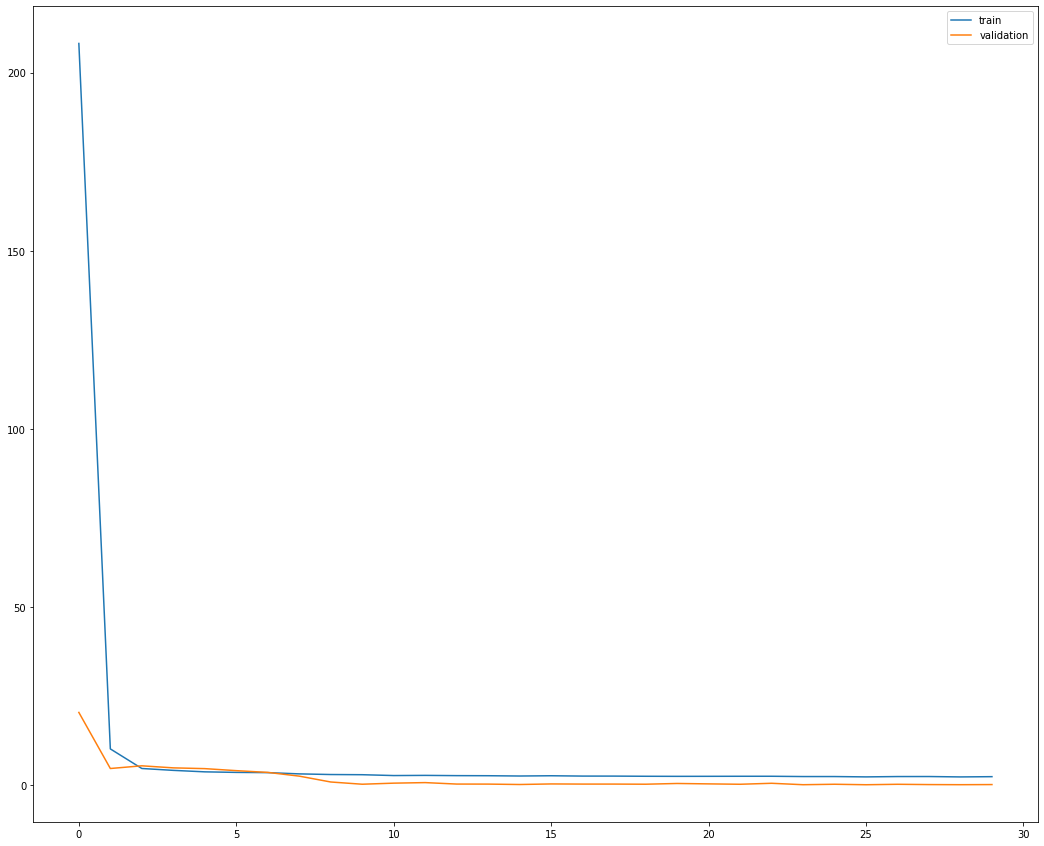

In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()

In [ ]:
ypred = model.predict(xtest)

In [ ]:
import numpy 
from math import sqrt
scores = []
rmse = sqrt(mean_squared_error(ytest, ypred))
scores.append(rmse)
print('RMSE:%.3f' % (rmse))


RMSE:26.385


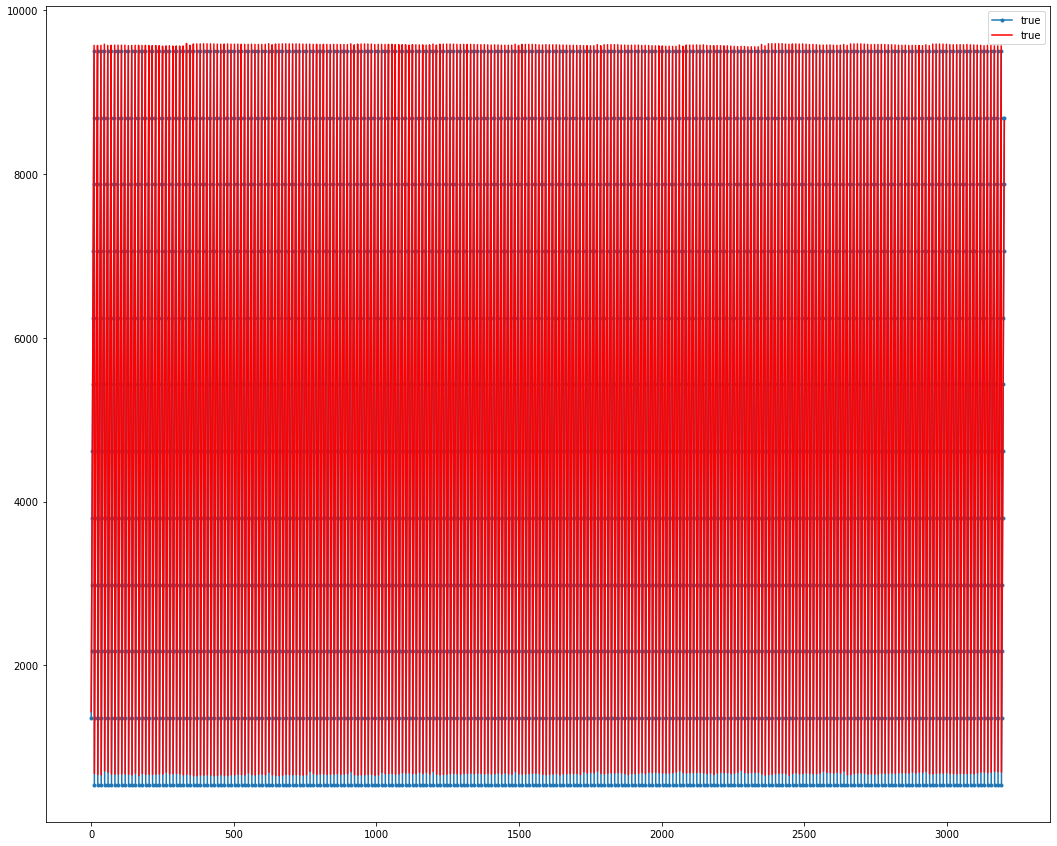

In [ ]:
plt.plot(y_test_pred.squeeze(),marker='.',label='true')
plt.plot(y_pred_int.flatten(),'r',label='true')

plt.legend()

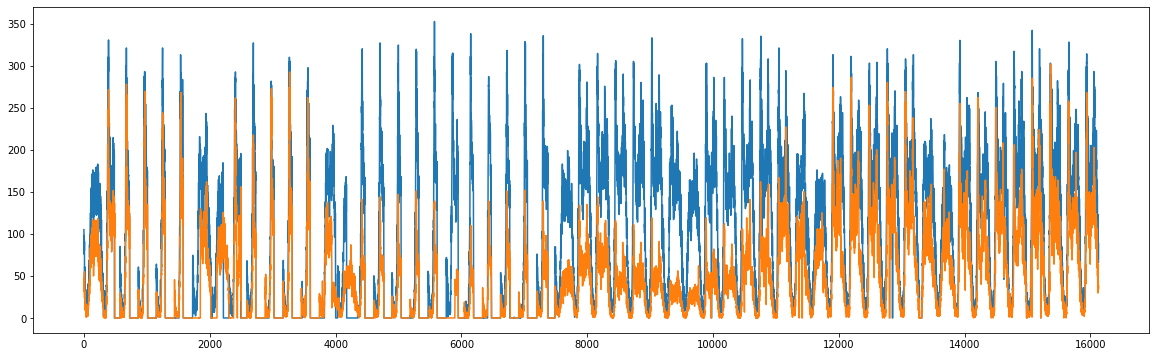

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,6))
plt.plot(df1)

In [ ]:
#correlation between the different variable
from statsmodels.tsa.stattools import grangercausalitytests
geanger_test = sm.tsa.stattools.grangercausalitytests(data,maxlag=6,verbose=True)
geanger_test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=877.3591, p=0.0000  , df_denom=16120, df_num=1
ssr based chi2 test:   chi2=877.7401, p=0.0000  , df=1
likelihood ratio test: chi2=854.6866, p=0.0000  , df=1


ValueError: ignored

DATA PREPARATION

In [ ]:
from sklearn.model_selection import train_test_split
nobs = 12000
df_train, df_test = data[-nobs:],data[0:-nobs]
len(df_train)
df_train.tail()
#len(df_test)

,Cross 1,Cross 2,Cross 3,Cross 4,Cross 5,Cross 6
16123,85.0,37.0,34,56.0,35,89.0
16124,71.0,45.0,44,50.0,44,53.0
16125,83.0,34.0,34,61.0,44,77.0
16126,89.0,39.0,25,48.0,32,64.0
16127,66.0,36.0,26,50.0,37,55.0


In [ ]:
#checking for the stationarity
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
  dftest = adfuller(ts, autolag='AIC')
  adf = pd.Series(dftest[0:5],index=['Test Statics','p-value','#','lags','# observations'])
  for k,value in dftest[4].items():
    adf['Ctintical Value(%s)'%k] = value
  print(adf)
  p=adf['p-value']
  if p<=signif:
    print(f"series is stationary")
  else:
    print(f"is non-sattionary")
adf_test(df_train['Cross 1'])
adf_test(df_train['Cross 2'])


Test Statics                                                     -11.0982
p-value                                                       3.92542e-20
#                                                                      14
lags                                                                11985
# observations          {'1%': -3.430895740603843, '5%': -2.8617811892...
Ctintical Value(1%)                                               -3.4309
Ctintical Value(5%)                                              -2.86178
Ctintical Value(10%)                                              -2.5669
dtype: object
series is stationary


KeyError: ignored

In [ ]:
df_differenced = df_train.diff().dropna()
adf_test(df_differenced['Cross 1'])


Test Statics                                                     -26.0695
p-value                                                                 0
#                                                                      12
lags                                                                11986
# observations          {'1%': -3.4308956950625826, '5%': -2.861781169...
Ctintical Value(1%)                                               -3.4309
Ctintical Value(5%)                                              -2.86178
Ctintical Value(10%)                                              -2.5669
dtype: object
series is stationary


In [ ]:
#fitting model 
model = sm.tsa.VARMAX(df_differenced)
result = model.fit(maxlags=15, ic = 'aic')
#result.summary()
result.plot_dianostics()


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Dep. Variable:,"['Cross 1', ' Cross 2', ' Cross 3', ' Cross 4', ' Cross 5', ' Cross 6']",No. Observations:,11999
Model:,VAR(1),Log Likelihood,-288416.944
,+ intercept,AIC,576959.889
Date:,"Sun, 03 May 2020",BIC,577425.621
Time:,10:05:20,HQIC,577116.118
Sample:,0,,
,- 11999,,
Covariance Type:,opg,,
Ljung-Box (Q):,"446.60, 926.75, 505.93, 2011.98, 932.68, 1529.48",Jarque-Bera (JB):,"55860.20, 36368.73, 9629.65, 19162.83, 10566.21, 20187.09"
Prob(Q):,"0.00, 0.00, 0.00, 0.00, 0.00, 0.00",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"1.76, 4.89, 1.68, 1.79, 2.01, 1.73",Skew:,"-0.36, -0.03, -0.06, -0.19, 0.03, -0.16"


In [ ]:
#forecasting
lag_order = result.k_ar
result.forecast(data.values[-lag_order:],5)

array([[ -2.51004521,   0.37696564,  35.42718124,  48.06198599,
         -5.26081849, -21.17026138],
       [ 21.76159054,  12.05477907,  15.12684012,  21.02423599,
         13.59264063,  24.36963249],
       [ 22.03668238,   8.65261058,  13.97642881,  20.9099885 ,
         10.3199526 ,  26.67244825],
       [ 17.82228963,   6.55189706,  11.48420497,  21.21885463,
          8.87375722,  14.10752444],
       [ 16.31154259,   7.06351355,  10.01324956,  17.30335665,
          8.34952021,  16.41006072]])

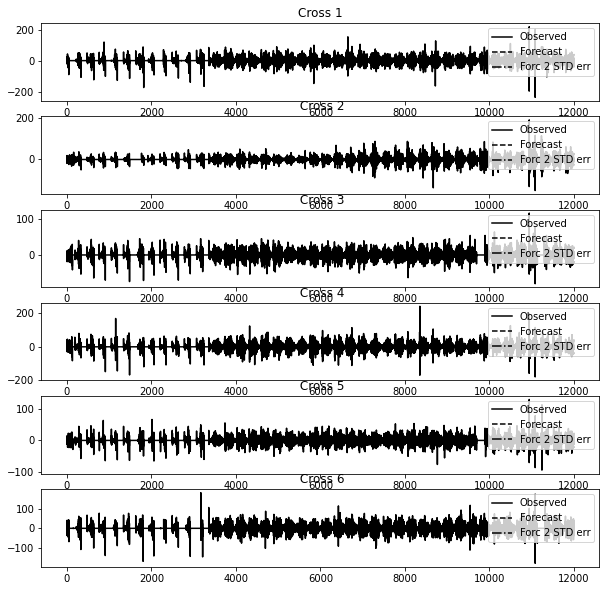

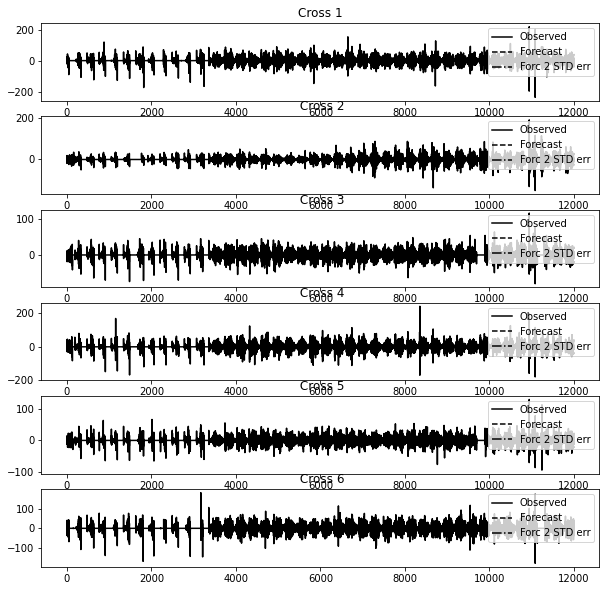

In [ ]:
result.plot_forecast(6)

In [ ]:
#evaluating 
fevd = result.fevd(5)
fevd.summary()

FEVD for Cross 1
      Cross 1   Cross 2   Cross 3   Cross 4   Cross 5   Cross 6
0    1.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1    0.955309  0.006613  0.011530  0.016663  0.003353  0.006532
2    0.952377  0.006828  0.012245  0.018394  0.003344  0.006812
3    0.951699  0.007040  0.012230  0.018450  0.003672  0.006910
4    0.949292  0.007039  0.013066  0.018384  0.004016  0.008203

FEVD for  Cross 2
      Cross 1   Cross 2   Cross 3   Cross 4   Cross 5   Cross 6
0    0.075439  0.924561  0.000000  0.000000  0.000000  0.000000
1    0.057852  0.931605  0.004683  0.002595  0.003245  0.000020
2    0.057754  0.930281  0.005665  0.002724  0.003523  0.000054
3    0.057845  0.930101  0.005648  0.002780  0.003567  0.000058
4    0.061765  0.924415  0.007212  0.002777  0.003639  0.000191

FEVD for  Cross 3
      Cross 1   Cross 2   Cross 3   Cross 4   Cross 5   Cross 6
0    0.025744  0.020533  0.953723  0.000000  0.000000  0.000000
1    0.020307  0.016210  0.931142  0.001588  0.02

In [ ]:
pred = result.forecast(result.y , steps=nobs)
df_forecast = pd.DataFrame(pred,index=data.index[-nobs:],columns=data.columns+'_1d')
df_forecast.tail()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


,Cross 1_1d,Cross 2_1d,Cross 3_1d,Cross 4_1d,Cross 5_1d,Cross 6_1d
16123,-0.003589,-0.000439,-0.001631,-0.002284,0.000292,-0.003399
16124,-0.003589,-0.000439,-0.001631,-0.002284,0.000292,-0.003399
16125,-0.003589,-0.000439,-0.001631,-0.002284,0.000292,-0.003399
16126,-0.003589,-0.000439,-0.001631,-0.002284,0.000292,-0.003399
16127,-0.003589,-0.000439,-0.001631,-0.002284,0.000292,-0.003399


In [ ]:
#inverting TRansformation
def invert_transformation(df_train,df_forecast,second_diff=False):
  """ revert back the difference to get the forecast to original scale"""
  df_fc = df_forecast.copy()
  columns = df_train.columns
  for col in columns:
    if second_diff:
      df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2])+df_fc[str(col)+'_1d'].cumsum()
      df_fc[str(col)+'_forcast']  =df_train[col].iloc[-1]+df_fc[str(col)+'_1d'].cumsum()
    return df_fc 


In [ ]:
df_results= invert_transformation(df_train,df_forecast,second_diff=True)
df_results

,Cross 1_1d,Cross 2_1d,Cross 3_1d,Cross 4_1d,Cross 5_1d,Cross 6_1d,Cross 1_forcast
4128,-17.606628,-1.489974,0.600503,-4.851517,-5.105332,1.380240,48.393372
4129,-20.446665,-0.088028,-0.179749,1.143857,-0.037185,4.628194,27.946707
4130,-19.621564,-1.269124,-1.473450,0.686141,-0.199411,-1.814525,8.325143
4131,-20.075310,1.385839,1.376147,2.136771,1.413853,-1.892856,-11.750167
4132,-18.603755,2.194020,-0.204223,-1.816398,0.905635,2.159552,-30.353921
...,...,...,...,...,...,...,...
16123,-67.001706,-0.000439,-0.001631,-0.002284,0.000292,-0.003399,-545411.790813
16124,-67.005295,-0.000439,-0.001631,-0.002284,0.000292,-0.003399,-545478.796108
16125,-67.008884,-0.000439,-0.001631,-0.002284,0.000292,-0.003399,-545545.804992
16126,-67.012473,-0.000439,-0.001631,-0.002284,0.000292,-0.003399,-545612.817464


In [ ]:
 from math import sqrt
 from sklearn.metrics import mean_squared_error
 rmse = sqrt(mean_squared_error(df_results['Cross 1_1d'],df_forecast['Cross 1_1d']))
 print(rmse)

47.14708921791737
